# Image compression using autoencoders: a deep learning task

Time : 8h

# Goal of this lab

* Get to know deep learning and PyTorch framework
* Learn how to compress images using autoencoders
* Understand the differences between JPEG compression and deep learning-based compression
* Know how to read and use code given by someone else


# Disclaimer

We will refer to :
- AutoEncoder as AE
- Multi Layer Perceptron as MLP

Please make sure that your environment has a GPU. For that, go to:
* Execution
* Modifier le type d'execution
* Accelerateur matériel: GPU

# 0 - Introduction

We have seen JPEG compression, a general algorithm that can compress any image. Let's first see your understanding of the JPEG algorithm :

<font color=red> **Questions** </font>
* What are the component in the encoding part of the algorithm ?
>In order to encode an image in JPEG format, we need to follow the following steps:
>0. (Optional, for more efficiency) Convert the RGB image to YCbCr chrominance.
>1. Decompose the image into pixel blocks of size 8 * 8. If the number of rows or columns is not a multiple of 8, apply a padding beforehand.
>2. Perform several calculations on the block (centring, DCT, zigzagging of the block)
>3. Encoding long sequences of zeros according to a specific rule (e.g. 0 0 0 0 by 257 4)
>4. Construct and use a Huffman table for encoding.

* What are the component in the decoding part of the algorithm ?
>In order to decode a JPEG image, we need to follow the above steps in reverse order
>1. Decode (using the correct dictionary) the Huffman code used.
>2. Decode long sequences of zeros according to a specific rule (e.g. 257 4 by 0 0 0 0)
>3. Perform several calculations on the block (cancellation of the zigzag path, IDCT, decentring)
>4. Recompose the blocks into an image in the correct order. Undo padding if it has been done
>5. (Optional, if done at encoding) Convert the image back to RGB.

* Is the down-sampling phase of JPEG linear ? (i.e : in a y = ax+b form)
> JPEG compression is not linear because during compression some samples are removed.
* Is it a lossless compression algorithm ?
>Compression is not lossless, however we have to make a compromise between having a good compression ratio and keeping a good quality image.

## a- Your mission: AI for the Win

Hi there, we are a Big Company and we need your help as a data scientist. We have some images to compress. We tried the JPEG algorithm but we also want to try some modern methods based on deep learning (DL).


In [28]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transform
import torchvision
import time

## b - Reading the documents

**Very important: take 20-25 minutes to read the following documentation to understand the basic.**



### i - What is deep learning ?

Deep Learning is a branch of AI where you **teach a Model** a certain **task** using a **Dataset**. The model or a neural network is built by multiple consecutive **layers** of neuron-like units, remotely based on neurons in the human brain. Typically, many consecutive layers are used, that is why it is referred to as deep learning. In those layers, each neuron has several **parameters** (**weights**) that are updated during **training** by minimizing a **loss** (error) function, using **Stochastic Gradient Descent**. Besides the model parameters, to be found using a dataset, there are also **hyperparameters** that you have to tune by yourself, for example, how many layers used in your model, how many neurons per layer,.... The Model infers a prediction from an **input**. In fact, a Deep Neural Network can be seen as a complex function ${f}$ that maps the input data to a learned space from the Dataset.

Note the bold words. These are the important things you need to understand about Deep Learning.

### ii- Generalities on AutoEncoder

<img src = "https://blog.keras.io/img/ae/autoencoder_schema.jpg">

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. In almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on.

2) Autoencoders are lossy.

3) Autoencoders are learned automatically from data examples.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation. In fact, we can look at the model as a big function :

* Encoder : This part compresses the input image to a compressed version of it, where $f(x)= z$, where $x$ is the input image, and $z$ the compressed representation of it.
* Decoder : This part of the model decompresses the compressed representation $z$ to the decompressed image $\tilde{x}$, in other terms we have a function $g$ where, $\tilde{x} = g(z)$
* AutoEncoder : by stacking the Encoder and the Decoder, and as we want $\tilde{x} = x$ (a.k.a the reconstructed image as similar as the input image), we can rewrite the AE as $\tilde{x} = g(z) = g\circ f(x)=  x$ where $g= f^{-1}$



### iii - Layers

A Layer is an important part of a model. In fact, it is the key element of a DL model. A Layer is a structure that takes information from one layer to pass them to the next layer. In a DL network, each layer extracts some kinds of features.

### iv -  Activation functions

An (non-linear) activation function decides the output of a neuron. It is the equivalent of the excitation threshold for which a neuron reacts or not. **Hints: as activation function in hidden layers, ReLU is often used while sigmoid is not used, due to their properties, notably the calcul complexity of their gradient used for the backpropagation.**

<img src = "https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png" height = 200>

---
# 1- Exploring the data

## Dataset

<img src="https://labelyourdata.com/img/article-illustrations/splitting_data.png" height=200>


When training  a DL model, we use a Dataset. The model uses the data to learn something for a task. We usually divide the data into Training, Validation, Test sets.
- Training set is used to train the Model (i.e., to find the parameters of Model).
- Validation set is used to watch the Model's training (to verify whether the training procedure goes well).
- Test set is used to evaluate the performance of the Model (in our case, to measure if the model compresses and decompresses well new images).

**In our case of AE, we do not need the label of image. Our method is an unsupervised algorithm.**

### a - The first one : the training set

<font color=red>  **Questions**  </font>
- What is the size of the training dataset?
> There are 55,000 items in the training dataset.
- What are the elements available in one piece of data? (image, label)
> The image is the drawing of the number. The label is the value of the drawn number.
- What is the shape of one piece of data?
> Each piece of data is a 28 by 28 pixel square.
- What is the type of one piece of data?
> A data element is composed of the image which is a tensor and an integer.
- Plot few elements of the dataset using matplotlib (plt since matplotlib was imported as plt).

The len of the dataset is 60000
The shape of an image is torch.Size([1, 28, 28])
The type of a image is <class 'torch.Tensor'>
The type of a label is <class 'int'>


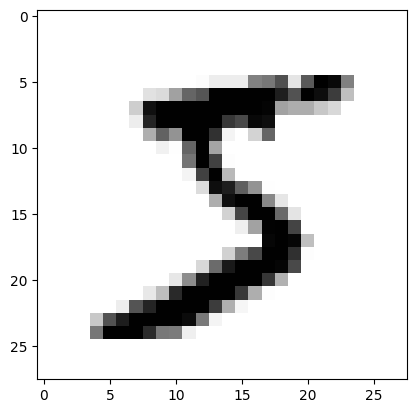

In [29]:
# Load MNIST Train dataset from TorchVision

dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())

# Show the value of size_of_dataset

size_of_dataset = len(dataset)

print(f"The len of the dataset is {size_of_dataset}")

# Retrieve one element of the Dataset ? What is the shape of one piece of Data ?

data_0 = dataset[0]
print(f"The shape of an image is {data_0[0].shape}")
print(f"The type of a image is {type(data_0[0])}")
print(f"The type of a label is {type(data_0[1])}")

# Plot the retrieved Data
plt.imshow(data_0[0].permute(1, 2, 0)[...,0], cmap='gray_r')

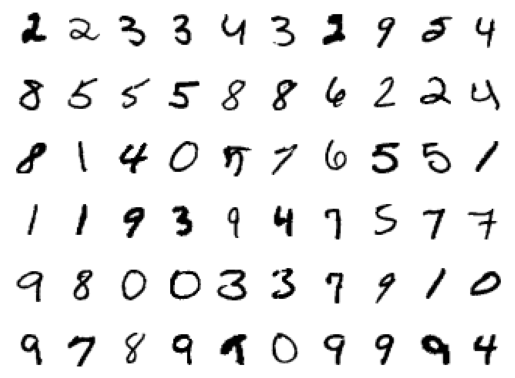

In [30]:
# Run them to see more about the dataset

loader_example = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
dataiter = iter(loader_example) # creating a iterator
data, labels = next(dataiter)
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(data[index].numpy().squeeze(), cmap='gray_r')

### b - The second one: the test dataset

As you can see in the above code, there's a "train" attribute of the MNIST class. When it is set to True, you are loading the training dataset. Therefore, in the following code, change it to false to load the test dataset.

In [31]:
# Load the test dataset.

train = False

mnist_test = MNIST('', train=train, download=True, transform=transforms.ToTensor())

The shape of a single piece of data is : torch.Size([1, 28, 28])
The value of target is : 3



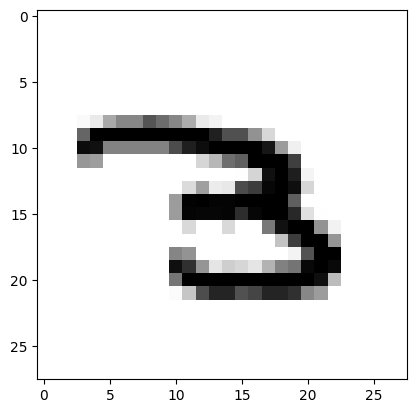

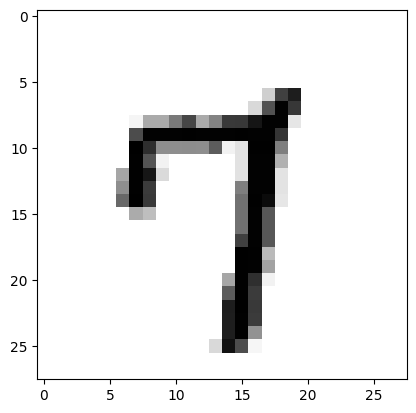

In [32]:
# Retrieve one element of the Dataset ? What is the shape of one piece of Data ?

data_250, target_250 = dataset[250]

data_750, target_750 = dataset[750]

print(f"The shape of a single piece of data is : {data_250.shape}")
print(f"The value of target is : {target_250}\n")

# Plot the retrieved Data

plt.imshow(data_250.permute(1, 2, 0)[...,0], cmap='gray_r')
plt.show()
plt.imshow(data_750.permute(1, 2, 0)[...,0], cmap='gray_r')
plt.show()

<font color=red> **Comment**  </font>
> Each element is 1 * 28 * 28: this is consistent because we have one colour, and each number is drawn in a 28 bit square.
>
> The value recorded in target corresponds to the number that is drawn: the objective could be to train an AI to recognise the number that is drawn. Our objective here will not be that, but rather to redraw the original image.

### c - The third one: creating the Validation dataset

Besides the training and testing sets, we would have a validation set. The validation set allows us to follow the training of model or in another words, to verify whether the training procedure goes well.

<font color=red> **Questions** </font>

In the next codes,
- What do 55000 and 5000 mean ?
> The first value will be the number of elements we have in the test part, while the second will be the number of elements in the validation part.
- Determine the split value of the training set to create the validation dataset
> Here, the split value is 55000.

In [33]:
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

### d - Creating the Dataloader

The dataset returns one element at a time. In DL, we like sending many items at the same time to the model. We form BATCH of Data using a DataLoader. Dataloader is iterable over the dataset. It means that the Dataloader will form BATCH of Data for you and fetch them.

- Create a DataLoader for your Training, Validation and Test dataset (do not change the third attribute)

More information on dataloader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [34]:
mnist_train_loader = DataLoader(mnist_train, batch_size=128, drop_last = True)
mnist_val_loader = DataLoader(mnist_val, batch_size=128, drop_last = True)
mnist_test_loader = DataLoader(mnist_test, batch_size=128, drop_last = True)

---
# 2 - Coding functions to avoid repeting myself

For a better understanding of this LAB, I decided to create some functions that will be called for training our models. My functions has a lot of optionnal parameters because I will use more often the AutoEncoder.

## a - TrainingAndValidationLoop

Let's start with the first function, **trainingAndValidationLoops**. This function will be called to train our models through training and Validation loops.

In [35]:
def trainingAndValidationLoop(model,
                              device,
                              train_loader = mnist_train_loader,
                              val_loader = mnist_val_loader,
                              mini_batches_print = 10,
                              num_epochs = 10,
                              learning_rate =  1e-3,
                              printValues = True,
                              reshapeImage = True):

  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  criterion = nn.MSELoss()
  net = model.to(device)
  loss_train , loss_val = [], []
  total_training_time = 0.0

  for epoch in range(num_epochs) :
    if printValues:
      print(f"epoch n°{epoch}")
    running_loss_t,running_loss_v = 0.0, 0.0

    training_start = time.time()
    # Create the Training Loop
    for i, data in enumerate(train_loader, 0):

      # Load the data into two variables
      image, label = data

      # Reshape the input image using (if necessary) and send values to device
      # Don't forget the Batch Size, the 1st dimension must always be the Batch Size
      if reshapeImage:
        image_reshaped, label = image.view(image.shape[0],-1).to(device), label.to(device)
      else:
        image_reshaped, label = image.to(device), label.to(device)
      optimizer.zero_grad()

      # Send the reshaped image to the model
      outputs = net(image_reshaped)
      outputs = outputs.view(image.size())

      # Compute the loss between outputs and image.
      # Send the image to the device
      loss = criterion(outputs, image.to(device))

      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == mini_batches_print :
        running_loss_t= running_loss_t/mini_batches_print
        if printValues:
          print(f"Training loss is   : {running_loss_t}")
        loss_train.append(running_loss_t)

    training_end = time.time()
    total_training_time += training_end - training_start

    # Create the Validation Loop
    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):

        # Load the data into two variables
        image, label = data

        # Reshape the input image using (if necessary) and send values to device
        if reshapeImage:
          image_reshaped, label = image.view(image.shape[0],-1).to(device), label.to(device)
        else:
          image_reshaped, label = image.to(device), label.to(device)

        # Send the reshaped image to the model
        outputs = net(image_reshaped)
        outputs = outputs.view(image.size())

        # Compute the loss between outputs and image.
        # Send the image to the device
        loss = criterion(outputs, image.to(device))

        running_loss_v += loss.item()
        if i == mini_batches_print :
          running_loss_v= running_loss_v/mini_batches_print
          if printValues:
            print(f"Validation loss is : {running_loss_v}\n")
          loss_val.append(running_loss_v)

  return (loss_train, loss_val, total_training_time)

## b - plotTrainingAndValidationLoss

In order to see the loss clearly (and make sure it decreases correctly), I've coded the following function. Its input parameters are those returned by the previous function.

In [36]:
def plotTrainingAndValidationLoss(loss_train, loss_val):
  plt.plot(loss_train, label="loss train")
  plt.plot(loss_val, label="loss validation")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

## c - testingLoop

After training our model, it is important to see how well it performs on new data (from the test bank).

Here's the **testingLoop** function that does just that:

In [37]:
def testingLoop(model,
                test_loader = mnist_test_loader,
                plotLastBatch = True,
                printDecompressionError = True,
                reshapeImage = True):
  net = model.to(device)
  with torch.no_grad():
    losses = 0
    for i, data in enumerate(test_loader, 0):
      image, label = data

      if reshapeImage:
        image_reshaped, label = image.view(image.shape[0],-1).to(device), label.to(device)
      else:
        image_reshaped, label = image.to(device), label.to(device)

      outputs = net(image_reshaped)
      outputs = outputs.view(image.size())
      loss = criterion(outputs, image.to(device))

      losses += loss

  if plotLastBatch:
    imshow(torchvision.utils.make_grid(outputs.detach().cpu()),'Pred')
    imshow(torchvision.utils.make_grid(data[0]),'GT')

  if printDecompressionError:
    print(f"The decompression of the Encoded Test Dataset has an reconstruction error of: {losses}")

  return losses

---
# 3 - Creating and training the model: AutoEncoder

We saw what the data was and created our datasets. We need now to fullfil our mission and we need a model.

We are going to explore the path of AutoEncoder! Let's write some readable codes. Our code must be modulable and easy to read. We should try two types of AutoEncoders :
- MLP Style
- Conv Style


Use PyTorch and Create Modulable and Stackable Models that inherits from nn.Module.




## a - MLP Style : Exploring the Neurons

<img src='https://www.researchgate.net/publication/344394387/figure/fig1/AS:974657746399232@1609387923440/Figure-Computational-Schematics-of-the-MLP-and-the-autoencoder.png'>

We will first try a MLP AE.




#### Creating a Model in PyTorch

Creating a model in PyTorch is simple. A PyTorch is an object that inherits from nn.Module. The pseudo-code is the following :

```
class Model(nn.Module):
  def __init__(self,...):
    """"
    Define the model. You can put the input size as a parameter if needed..
    """"
    super().__init__() # to init the main class
    self.layers = ... # defining the model : could be Conv2d, Linear, RNN, LSTM


  def forward(self,x):
    """
    The input x is forwarded through the neural net.
    """
    output = self.layers(x)
    return output

  # Other methods go down
```

More informations : https://pytorch.org/docs/stable/nn.html


### i - Creating the AutoEncoder

First, we will try a really simple model :
* an Input Dense layer
* a latent space
* an Output Dense layer

In [38]:
# We have in this lab a variable called 'compressed_space_size' but it is
# actually 'latent_space_size' that we will see later.

class AutoEncoder_MLP(nn.Module):
  def __init__(self, input_size, compressed_space_size):
    """
    The model is an Input Layer, a Hidden Layer and an Output layer
    """
    super().__init__()
    # Init the class attributes thanks to the arguments of the init methods
    self.input_size = input_size
    self.output_size = input_size
    self.compressed_space_size = compressed_space_size
    self.input = nn.Sequential(nn.Linear(self.input_size,
                                         self.compressed_space_size))

    self.output = nn.Sequential(nn.Linear(self.compressed_space_size, self.output_size),
                                nn.Sigmoid())

  def forward(self,x):
    """
    The input x is forwarded through the neural net.
    """
    compressed_image = self.input(x)
    decompressed_image = self.output(compressed_image)
    return decompressed_image

In [39]:
# Create an Instance of the Model

model = AutoEncoder_MLP(input_size = 28*28,
                        compressed_space_size = 1)

# Print the model
print(f"The current model is :\n\n{model}")

The current model is :

AutoEncoder_MLP(
  (input): Sequential(
    (0): Linear(in_features=784, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=1, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


## b - Training

We can train the model. We have a Model and a Dataset. We need few more things..



### i - Loss function

The loss function must tell us how far our predictions are from the true labels. This could be done by comparing the distributions of two input data, or by directly comparing the data using some distance metrics.

We are reconstructing an image from its compressed version and we want  that the reconstructed image is similar to the original image. i.e $\tilde{x} = x$

More information: https://pytorch.org/docs/stable/nn.html#loss-functions

In [40]:
# Define the loss
criterion = nn.MSELoss()

### ii - An Optimizer

We need gradually update the weights of the model. In fact, we perform the **gradient descent** to recalculate the weights of each layer regarding the model's predictions. The optimizer will search for an Optimum. It needs a step to perform this research. This step is called the **learning rate**. The learning rate has an important effect on the learning phase (duration, convergence,...)

<img src=https://miro.medium.com/max/918/0*uIa_Dz3czXO5iWyI. height =300>

In this case, we will use Adam Optimizer (it is efficient). Don't hesitate to have a look at the other optimizers.

More information: https://pytorch.org/docs/stable/optim.html

In [41]:
# Define a small learning rate
learning_rate =  1e-3

# Load the Adam optimizer in the optimizer variable
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### iii - Training

Please use GPU to accelerate this phase.

Now we have to create the training loop which consists of :
* Sending Data through the model to obtain Predictions
* Computing the Loss
* Backwarding the Loss using Gradients
* Logging the losses and accuracies (if exists)

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

Gradient descent: think of it as you trying to answer an exercise : the first time you won't understand, the seconde time you'll suceed more, and so on...

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoEncoder_MLP(28*28,1)

loss_train, loss_val, _ = trainingAndValidationLoop(model, device)

epoch n°0
Training loss is   : 0.2721086576581001
Validation loss is : 0.13127752542495727

epoch n°1
Training loss is   : 0.12887434363365174
Validation loss is : 0.07646688520908355

epoch n°2
Training loss is   : 0.07568839266896248
Validation loss is : 0.0744321510195732

epoch n°3
Training loss is   : 0.07368238791823387
Validation loss is : 0.07326685190200806

epoch n°4
Training loss is   : 0.07253251001238822
Validation loss is : 0.07241053953766823

epoch n°5
Training loss is   : 0.07169657796621323
Validation loss is : 0.0717332161962986

epoch n°6
Training loss is   : 0.07102203890681266
Validation loss is : 0.0712352056056261

epoch n°7
Training loss is   : 0.07052692696452141
Validation loss is : 0.0708515014499426

epoch n°8
Training loss is   : 0.07014333009719849
Validation loss is : 0.0705432903021574

epoch n°9
Training loss is   : 0.06982312239706516
Validation loss is : 0.07033096551895142



### iv - Did it learn something ?

As you might see we've logged into two lists (train_loss, val_loss) of loss computed during training. Let's plot them.


<font color=red> **Question** </font>
- How can you tell that the training is over?
> We choose here to say that the training is finished after a certain number of epochs (10 for the sake of uniformity in the TP). We could also have asked that the training stops when the loss falls below a certain value, or even set a time and tell the model to train for that duration.

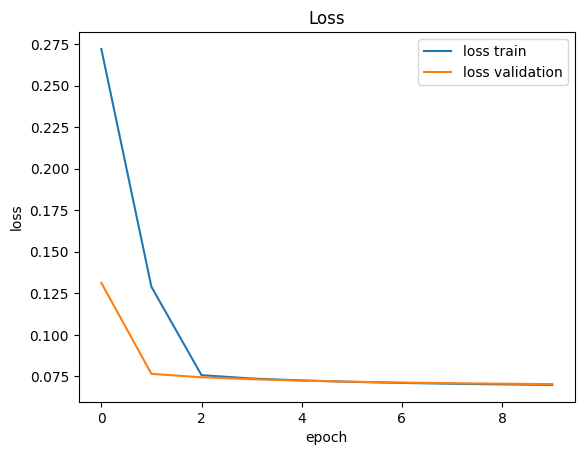

In [45]:
# Plot the train and val loss on the same graph

plotTrainingAndValidationLoss(loss_train, loss_val)

## c - Testing the compression

We already trained our model, let's test it on testing set. Here you go an email from the senior Data Scientist :


---

 🔊 🔊 🔊 **Message from the Senior Data Scientist** 🔊 🔊 🔊

Hi, this is C. the Senior Data Scientist

I heard that you've trained your model. Let's test it.
Take the test dataloader, iterate through it and send the test data to the model. We need to check how similar to the original image the decompressed image is..


---





<font color=red> **Question**</font>

* Why must we not compute the gradients for the testing step?
>During the test phase, no gradient should be calculated. It is only during the training phase that there is back-propagation.



In [43]:
def imshow(img,name= 'GT'):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(name)
  plt.show()

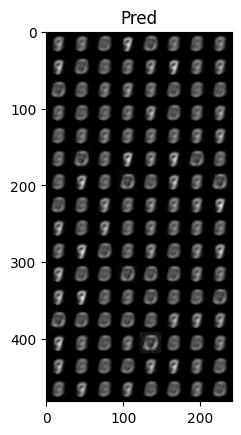

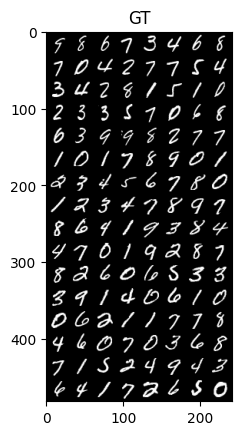

The decompression of the Encoded Test Dataset has an reconstruction error of: 4.985116004943848


tensor(4.9851, device='cuda:0')

In [ ]:
testingLoop(model)

<font color=red> **Remark**  </font>
> The reconstructed image is really blurry! We will see how the value of compressed_space_size will affect this effect.

<font color=blue> Let's see the effect of the compression: change the latent_size to different values. For example, try 512, 128, 16, 1. </font>

epoch n°0
Training loss is   : 0.24910544753074645
Validation loss is : 0.04747627638280392

epoch n°1
Training loss is   : 0.04809803515672684
Validation loss is : 0.03579581510275602

epoch n°2
Training loss is   : 0.03633803240954876
Validation loss is : 0.03127514477819204

epoch n°3
Training loss is   : 0.031855906918644906
Validation loss is : 0.028616816364228727

epoch n°4
Training loss is   : 0.02921939790248871
Validation loss is : 0.02676668968051672

epoch n°5
Training loss is   : 0.027408505603671075
Validation loss is : 0.02554106805473566

epoch n°6
Training loss is   : 0.026191236823797225
Validation loss is : 0.02478324230760336

epoch n°7
Training loss is   : 0.025426459684967994
Validation loss is : 0.024331181310117245

epoch n°8
Training loss is   : 0.024965691938996316
Validation loss is : 0.024052797071635722

epoch n°9
Training loss is   : 0.024685268849134447
Validation loss is : 0.02387324012815952



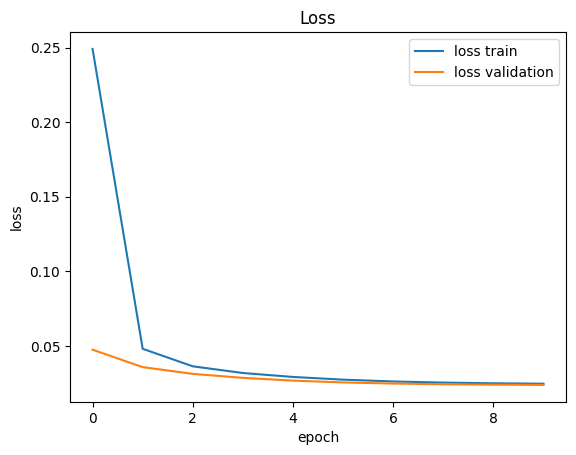

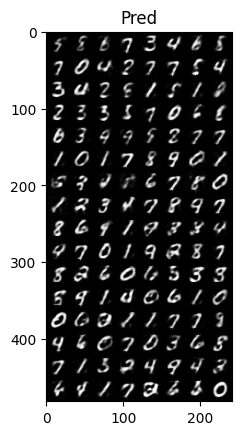

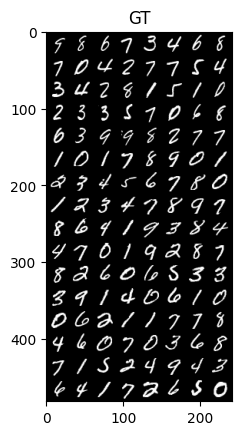

The decompression of the Encoded Test Dataset has an reconstruction error of: 1.6810146570205688


tensor(1.6810, device='cuda:0')

In [ ]:
model = AutoEncoder_MLP(28*28,16)

loss_train, loss_val, _ = trainingAndValidationLoop(model, device)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model)

epoch n°0
Training loss is   : 0.20335856899619104
Validation loss is : 0.018852170556783676

epoch n°1
Training loss is   : 0.019443264789879323
Validation loss is : 0.009025368466973304

epoch n°2
Training loss is   : 0.009365366026759147
Validation loss is : 0.005328416731208563

epoch n°3
Training loss is   : 0.005456184921786189
Validation loss is : 0.0039602327859029176

epoch n°4
Training loss is   : 0.004043696075677871
Validation loss is : 0.003252994641661644

epoch n°5
Training loss is   : 0.003310884931124747
Validation loss is : 0.0027971599018201234

epoch n°6
Training loss is   : 0.0028357121860608458
Validation loss is : 0.002470628428272903

epoch n°7
Training loss is   : 0.0024985904339700936
Validation loss is : 0.0022457782295532526

epoch n°8
Training loss is   : 0.0022657946916297077
Validation loss is : 0.002080850501079112

epoch n°9
Training loss is   : 0.002091388730332255
Validation loss is : 0.001953809114638716



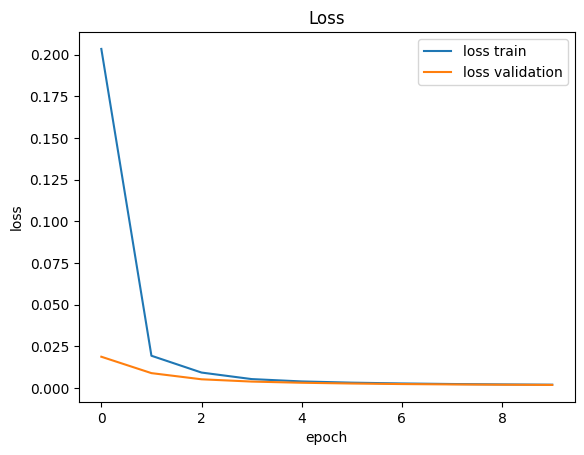

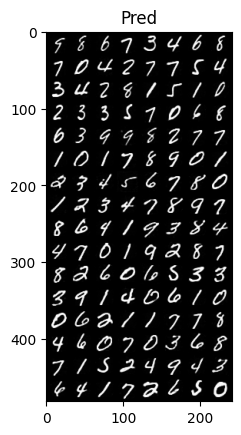

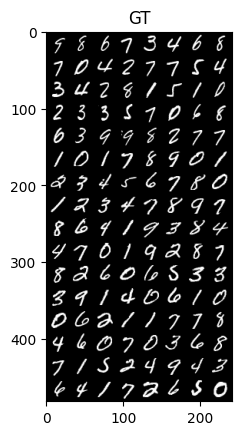

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.13654957711696625


tensor(0.1365, device='cuda:0')

In [ ]:
model = AutoEncoder_MLP(28*28,128)

loss_train, loss_val, _ = trainingAndValidationLoop(model, device)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model)

epoch n°0
Training loss is   : 0.1470276743173599
Validation loss is : 0.009439005982130766

epoch n°1
Training loss is   : 0.009694128856062889
Validation loss is : 0.0035653943428769707

epoch n°2
Training loss is   : 0.003604564699344337
Validation loss is : 0.0023816713597625493

epoch n°3
Training loss is   : 0.002410665946081281
Validation loss is : 0.0018510970519855618

epoch n°4
Training loss is   : 0.0018571520340628922
Validation loss is : 0.001520258083473891

epoch n°5
Training loss is   : 0.0015280530089512468
Validation loss is : 0.0013109269202686846

epoch n°6
Training loss is   : 0.0013140553841367365
Validation loss is : 0.0011606786050833763

epoch n°7
Training loss is   : 0.0011582309030927717
Validation loss is : 0.0010480355354957282

epoch n°8
Training loss is   : 0.0010412094241473823
Validation loss is : 0.0009664127370342612

epoch n°9
Training loss is   : 0.0009618358104489744
Validation loss is : 0.000899723352631554



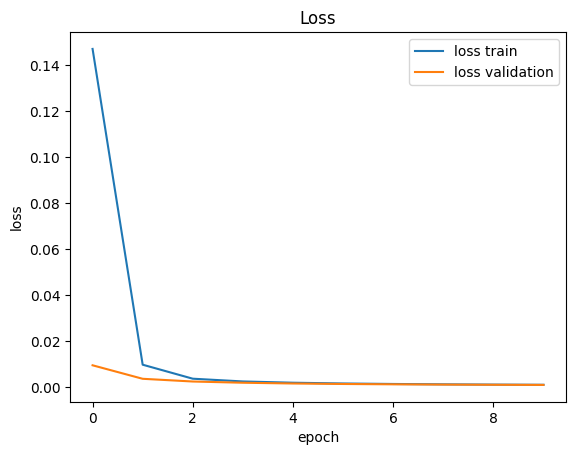

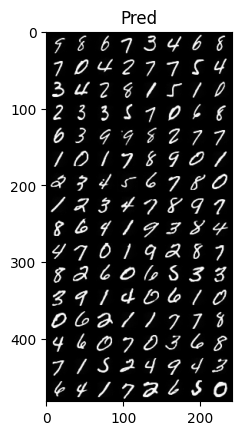

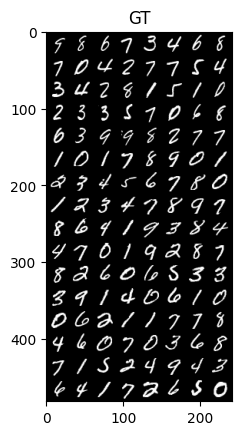

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.06378450244665146


tensor(0.0638, device='cuda:0')

In [ ]:
model = AutoEncoder_MLP(28*28,512)

loss_train, loss_val, _ = trainingAndValidationLoop(model, device)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model)

<font color=red> **Remark**

The larger our latent_space, the smaller the blurring effect (the reconstruction error).

## d - Testing on other type of data

We can say that the model works pretty well on the test data.

Let's test it on other kind of image.

* Write the code to test images taken from the internet.

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'Reconstructed image')

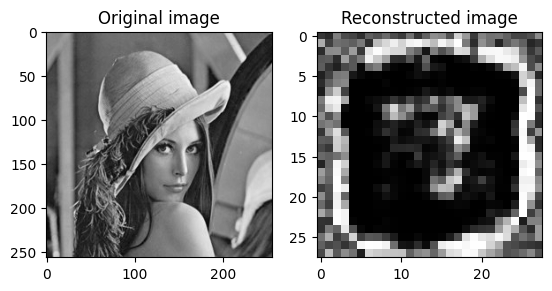

In [ ]:
model = AutoEncoder_MLP(28*28,512)

loss_train, loss_val, _ = trainingAndValidationLoop(model,
                                                 device,
                                                 printValues = False)

#  Test an images from the internet to see the compression effect
image_filename = "http://www.lenna.org/len_std.jpg"
image_numpy = cv2.cvtColor(skimage.io.imread(image_filename),cv2.COLOR_BGR2GRAY)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((28,28))])

# Transform the images and add a dimension for the batch size using unsqueeze
image = transform(image_numpy).unsqueeze(0).to(device)

# Send the model to the model and process the prediction.
image_reshaped = image.view(image.shape[0], -1).to(device)
pred = model(image_reshaped).view(image.size())

# Plot the results

pred = pred.detach().cpu()

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(image_numpy, cmap="gray")
axarr[0].set_title("Original image")
axarr[1].imshow(pred.squeeze().reshape(28,28), cmap="gray")
axarr[1].set_title("Reconstructed image")

* <font color=red> **What can you say ?** </font>
> It is badly reconstructed because the model is not trained on this type of data at all.

## <font color=red> e - BONUS : Plot of the testing loss as a function of the value of compressed space size. </font>

In [ ]:
compression_values = [2**i for i in range(0, 11)]
test_loss_values, time_training_values = [], []

# Get all last values of training loss
for i in compression_values:
  model = AutoEncoder_MLP(28*28, i)

  _, _, time_training = trainingAndValidationLoop(model,
                                                  device,
                                                  printValues = False)
  losses = testingLoop(model,
                       plotLastBatch = False,
                       printDecompressionError = False)
  test_loss_values.append(losses.item())
  time_training_values.append(time_training)

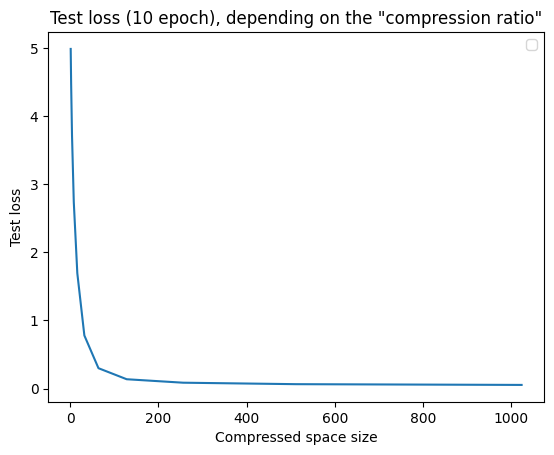

In [ ]:
plt.plot(compression_values, test_loss_values)
plt.legend()
plt.title("Test loss (10 epoch), depending on the \"compression ratio\"")
plt.xlabel("Compressed space size")
plt.ylabel("Test loss")
plt.show()

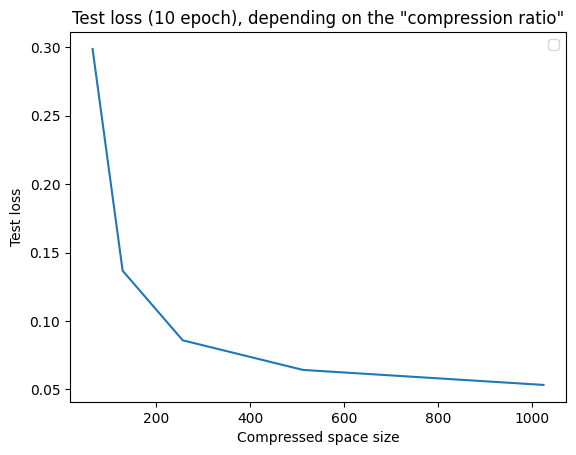

In [ ]:
plt.plot(compression_values[6:], test_loss_values[6:])
plt.legend()
plt.title("Test loss (10 epoch), depending on the \"compression ratio\"")
plt.xlabel("Compressed space size")
plt.ylabel("Test loss")
plt.show()

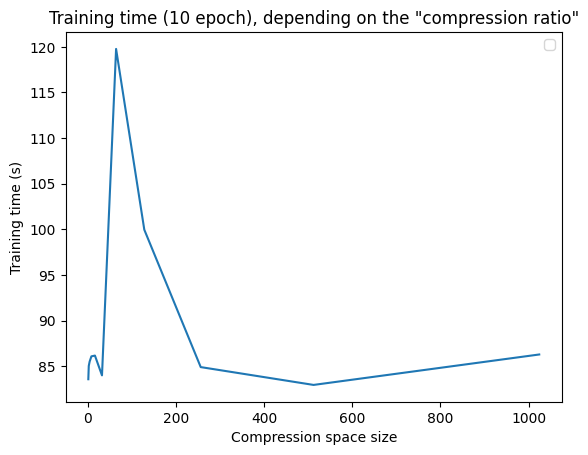

In [ ]:
plt.plot(compression_values, time_training_values)
plt.legend()
plt.title("Training time (10 epoch), depending on the \"compression ratio\"")
plt.xlabel("Compression space size")
plt.ylabel("Training time (s)")
plt.show()

<font color=red> **Remark**

Further remarks are done in the lab report.

# 4 - Convolutional layer style : seeing a region

<img src="https://miro.medium.com/max/1838/1*LSYNW5m3TN7xRX61BZhoZA.png" height = 300>

---
 🔊 🔊 🔊 **Message from the senior data scientist** 🔊 🔊 🔊

Hello,

Good work! We need now to try another type of model.
Please consider Conv2d layers.
Here you are some explanations: Convolutional Layers are filters that "scan" the input image in order to extract features. These filters extract features by looking at the region they're on.

I sent you some classes that you should use in your code.

**Take 5 minutes to learn more about convolution with the following link: **

* https://ezyang.github.io/convolution-visualizer/

Questions:
* What is the stride parameter?
* What is the padding parameter?
* What will change on the output when increasing the Kernel Size?

**Receptive field: are the pixels seen by filter kernel.**


## a - Model definition

Have a look at the model sent by the senior data scientist.

### i - Submodules

#### Conv Down

ConvDown is used to reduce the image size. A convolution on the input image is done using a kernel (the coefficients of kernel are weights to be found). In fact, it is used to extract interesting features of image. Our ConvDown Model will be composed of two layers:
* Conv2d layer
* Non linearity (ReLU)

<img src="https://www.jeremyjordan.me/content/images/2017/07/no_padding_no_strides.gif">

In [ ]:
class ConvDown(nn.Module):
  """
  This class takes as input the channels and returns a feature map
  for the given output channel.
  It indeed applies ReLU to it
  ConvDown stacks a Conv2d layer with an ReLU Activation
  """
  def __init__(self, input_channel, output_channel, kernel_size = 3):
    super().__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.kernel_size = kernel_size
    self.model = nn.Sequential(nn.Conv2d(self.input_channel, self.output_channel, kernel_size = self.kernel_size),
                                nn.ReLU())

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

#### Conv Up

ConvUp is used to decompress the input image. In fact, it uses extracted features to reconstruct output feature map.

<font color=red> **Question** </font>
* Is it possible to increase output size map using Conv2d layers?
> This is not possible using a single Conv2D layer because the moving core is constrained within the original image. On the other hand, by adding the Conv2DTranspose decoder layers, we can enlarge the output map of the autoEncoder if we do not strictly reverse the output parameters of our Decoder.

We can use also ConvTranpose2D layers, that use **transpose convolution** over an input image. These ConvTranspose layers learn to upsample the images.

<img src="https://miro.medium.com/max/1400/1*HnxnJDq-IgsSS0q3Lut4xA.gif" height=200>

In [ ]:
class ConvUp(nn.Module):
  """
  ConvUp stacks a Conv2d layer with an Activation
  If output is True : the Activation is Sigmoid
  If output is False : the Activation is ReLU
  """
  def __init__(self, input_channel, output_channel, kernel_size = 3 , output = True):
    super().__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.kernel_size = kernel_size
    self.output = output
    self.model = nn.Sequential(nn.ConvTranspose2d(self.input_channel, self.output_channel, kernel_size = self.kernel_size),
                                nn.ReLU()) if output is False else nn.Sequential(nn.ConvTranspose2d(self.input_channel, self.output_channel, kernel_size = self.kernel_size ),
                                nn.Sigmoid())

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

### ii - Modules : the wrappers

#### Encoder

The encoder stacks multiple ConvDown to compress and extract features.

<img src="https://i.imgflip.com/65bqe0.jpg" height=300>

In [ ]:
class Encoder(nn.Module):
  """
  The encoder stacks multiple ConvDown to compress and extract features
  For the moment, we just keep one ConvDown layer

  """
  def __init__(self, input_channel, output_channel, kernel_size = 3):
    super().__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.kernel_size = kernel_size
    self.model = nn.Sequential(ConvDown(self.input_channel, self.output_channel, self.kernel_size))

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

#### Decoder

The decoder stacks multiple ConvUp to decompress and upsamples the input.

<img src="https://i.imgflip.com/65br5o.jpg" height=300>

In [ ]:
class Decoder(nn.Module):
  """
  The Decoder stacks multiple ConvUp to upsample and reconstruct from the input
  another feature map
  For the moment, we just keep one ConvDown layer
  """
  def __init__(self, input_channel, output_channel, kernel_size = 3, output = True):
    super().__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.kernel_size = kernel_size
    self.output = output
    self.model = nn.Sequential(ConvUp(self.input_channel, self.output_channel, self.kernel_size, self.output))

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

### iii - The Conv AutoEncoder: final model

We stack encoder and decoder in order to form the autoencoder.


In [ ]:
# Stack the Encoder and the Decoder to Create the AE
# Be careful to respect the init attributes of the called class

class AutoEncoder_Conv(nn.Module):
  """
  The AutoEncoder stacks the Encoder and the Decoder
  """
  def __init__(self, input_size, latent_size, output= True):
    super().__init__()
    self.input_size = input_size
    self.latent_size = latent_size
    self.output = output
    self.model = nn.Sequential(Encoder(self.input_size, self.latent_size),
                               Decoder(latent_size, self.input_size, output = self.output))

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    return self.model(x)

In [ ]:
# Create an Instance of the Model

model = AutoEncoder_Conv(input_size = 1,
                        latent_size = 1)

# Print the model
print(f"The current model is :\n\n{model}")

The current model is :

AutoEncoder_Conv(
  (model): Sequential(
    (0): Encoder(
      (model): Sequential(
        (0): ConvDown(
          (model): Sequential(
            (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
          )
        )
      )
    )
    (1): Decoder(
      (model): Sequential(
        (0): ConvUp(
          (model): Sequential(
            (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
            (1): Sigmoid()
          )
        )
      )
    )
  )
)


## b - Training and Testing

We can reuse the previously written code. However, we need to make some changes...

* <font color=red> **What changes must we do ?** </font>

> We no longer call it the same model. Also, we have to be careful: the first value is the number of colours (here one) and the second the size of the latent_space.

epoch n°0
Training loss is   : 0.2507436990737915
Validation loss is : 0.002231167512945831

epoch n°1
Training loss is   : 0.002230361313559115
Validation loss is : 0.001190478156786412

epoch n°2
Training loss is   : 0.0012222438352182507
Validation loss is : 0.0009279536840040237

epoch n°3
Training loss is   : 0.0009584193408954889
Validation loss is : 0.0007592971785925328

epoch n°4
Training loss is   : 0.0007859764155000448
Validation loss is : 0.0006308001116849482

epoch n°5
Training loss is   : 0.0006545607757288963
Validation loss is : 0.0005289477529004216

epoch n°6
Training loss is   : 0.0005499434511875734
Validation loss is : 0.00045004005660302936

epoch n°7
Training loss is   : 0.00046863247989676894
Validation loss is : 0.0003906868805643171

epoch n°8
Training loss is   : 0.0004065030021592975
Validation loss is : 0.000343531888211146

epoch n°9
Training loss is   : 0.00035781288461294024
Validation loss is : 0.00030558294092770667



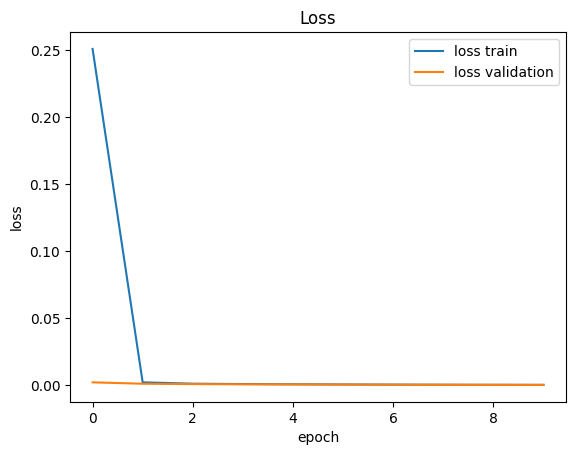

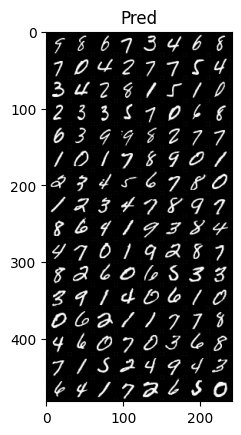

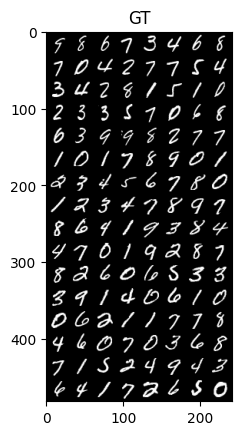

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.021770304068922997


tensor(0.0218, device='cuda:0')

In [ ]:
# Change your model
model = AutoEncoder_Conv(1, 64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, _ = trainingAndValidationLoop(model,
                                                    device,
                                                    reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

<font color=red> **Let's compare the results with different sizes (512, 128, 16, 1):**  </font>

epoch n°0
Training loss is   : 0.26788014024496076
Validation loss is : 0.15474994033575057

epoch n°1
Training loss is   : 0.1536287009716034
Validation loss is : 0.09652880430221558

epoch n°2
Training loss is   : 0.09582657665014267
Validation loss is : 0.063416014239192

epoch n°3
Training loss is   : 0.06296022795140743
Validation loss is : 0.04347153529524803

epoch n°4
Training loss is   : 0.04318049103021622
Validation loss is : 0.030837006121873855

epoch n°5
Training loss is   : 0.030649775452911854
Validation loss is : 0.022490903735160828

epoch n°6
Training loss is   : 0.022371157258749007
Validation loss is : 0.016798715107142925

epoch n°7
Training loss is   : 0.016723980940878392
Validation loss is : 0.012814630009233951

epoch n°8
Training loss is   : 0.012770742364227771
Validation loss is : 0.009958963748067618

epoch n°9
Training loss is   : 0.0099359723739326
Validation loss is : 0.007860088162124157



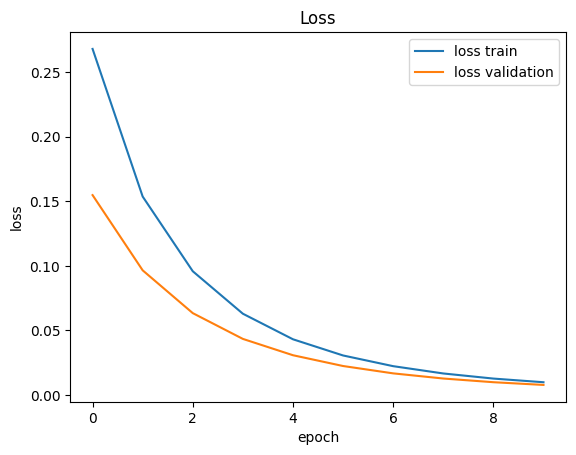

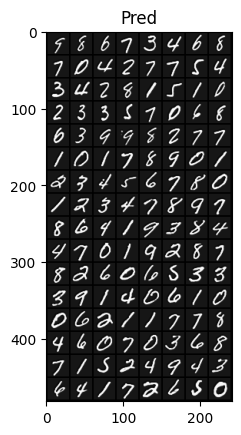

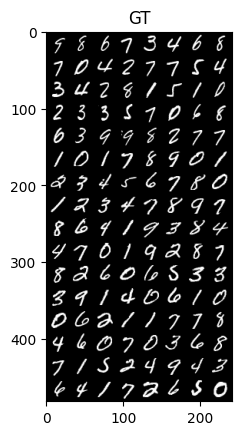

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.5545228719711304


tensor(0.5545, device='cuda:0')

In [ ]:
model = AutoEncoder_Conv(1, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, _ = trainingAndValidationLoop(model,
                                                    device,
                                                    reshapeImage = False)

plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

epoch n°0
Training loss is   : 0.21883596181869508
Validation loss is : 0.0034192784922197463

epoch n°1
Training loss is   : 0.0034152861451730134
Validation loss is : 0.001615461439359933

epoch n°2
Training loss is   : 0.001636706234421581
Validation loss is : 0.0011439943686127664

epoch n°3
Training loss is   : 0.0011651476263068617
Validation loss is : 0.0009244043903890997

epoch n°4
Training loss is   : 0.0009443088842090219
Validation loss is : 0.0007807412010151892

epoch n°5
Training loss is   : 0.0007984456664416939
Validation loss is : 0.0006727319734636695

epoch n°6
Training loss is   : 0.0006886915711220354
Validation loss is : 0.000595415965653956

epoch n°7
Training loss is   : 0.0006100460886955261
Validation loss is : 0.000536930951057002

epoch n°8
Training loss is   : 0.0005504538741661236
Validation loss is : 0.0004896803118754178

epoch n°9
Training loss is   : 0.000502228707773611
Validation loss is : 0.0004492246138397604



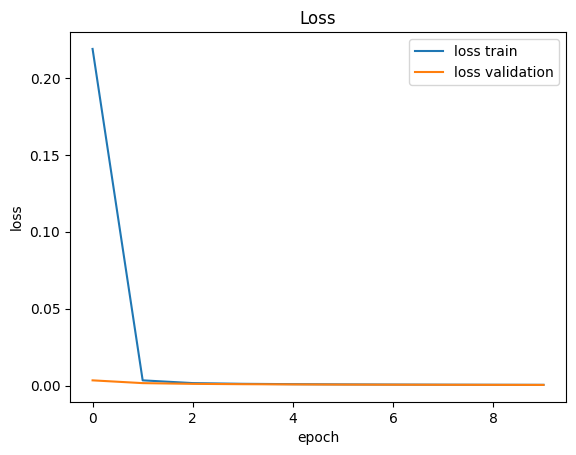

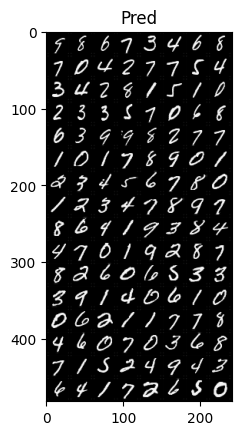

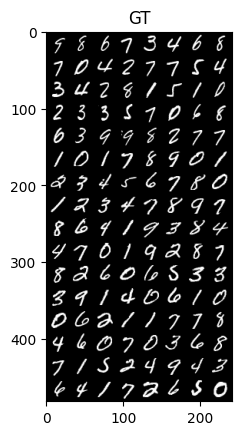

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.032131392508745193


tensor(0.0321, device='cuda:0')

In [ ]:
model = AutoEncoder_Conv(1, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, _ = trainingAndValidationLoop(model,
                                                 device,
                                                 reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

epoch n°0
Training loss is   : 0.25096054226160047
Validation loss is : 0.0020024535595439376

epoch n°1
Training loss is   : 0.002013606298714876
Validation loss is : 0.0011566401342861354

epoch n°2
Training loss is   : 0.001187189284246415
Validation loss is : 0.0008450721041299402

epoch n°3
Training loss is   : 0.0008701982733327895
Validation loss is : 0.0006584456306882203

epoch n°4
Training loss is   : 0.0006796128640417009
Validation loss is : 0.0005439057567855343

epoch n°5
Training loss is   : 0.0005627466482110322
Validation loss is : 0.00046535448054783044

epoch n°6
Training loss is   : 0.0004813348758034408
Validation loss is : 0.00040471953980159014

epoch n°7
Training loss is   : 0.0004180248739430681
Validation loss is : 0.0003553943970473483

epoch n°8
Training loss is   : 0.0003665813070256263
Validation loss is : 0.0003145334136206657

epoch n°9
Training loss is   : 0.0003239057579776272
Validation loss is : 0.0002803890616632998



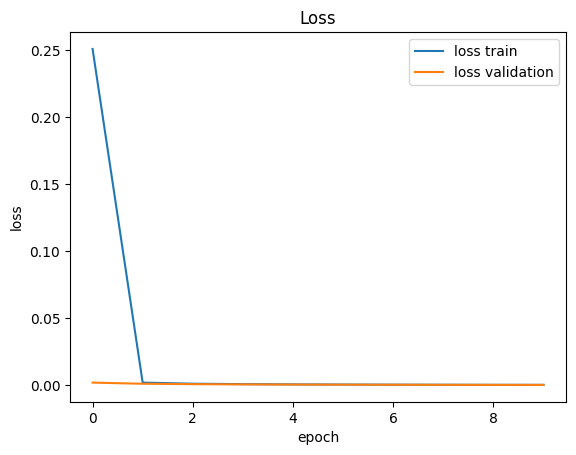

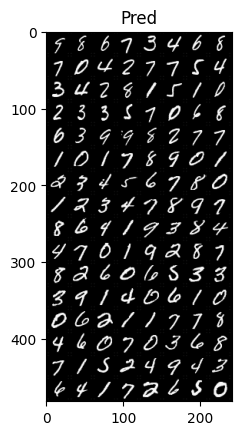

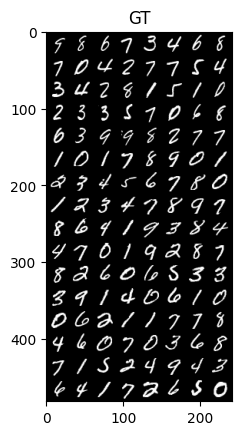

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.019590599462389946
The training time is 98.41320514678955 seconds.


In [ ]:
model = AutoEncoder_Conv(1, 64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, training_time = trainingAndValidationLoop(model,
                                                    device,
                                                    reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

print(f"The training time is {training_time} seconds.")

epoch n°0
Training loss is   : 0.3774965420365334
Validation loss is : 0.0015771703678183258

epoch n°1
Training loss is   : 0.0015938354888930916
Validation loss is : 0.0006847048585768789

epoch n°2
Training loss is   : 0.0007137354055885226
Validation loss is : 0.0004697371507063508

epoch n°3
Training loss is   : 0.0004896303842542693
Validation loss is : 0.0003566217405023053

epoch n°4
Training loss is   : 0.0003704762348206714
Validation loss is : 0.00026127663004444913

epoch n°5
Training loss is   : 0.0002701543431612663
Validation loss is : 0.0002006682494538836

epoch n°6
Training loss is   : 0.000206672256172169
Validation loss is : 0.0001588068073033355

epoch n°7
Training loss is   : 0.00016220235120272263
Validation loss is : 0.00012625331364688464

epoch n°8
Training loss is   : 0.00012848631740780547
Validation loss is : 0.00010304796378477477

epoch n°9
Training loss is   : 0.0001047497040417511
Validation loss is : 8.613657410023734e-05



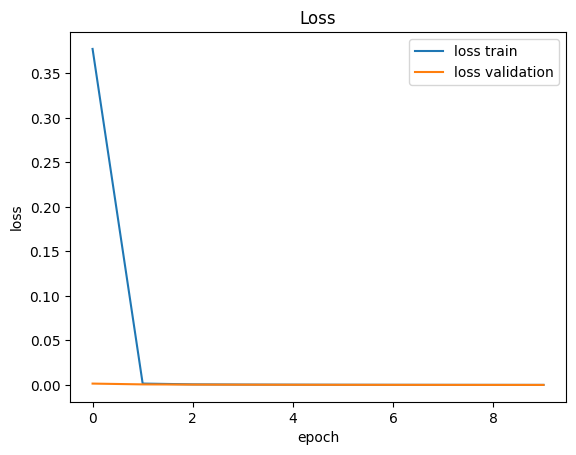

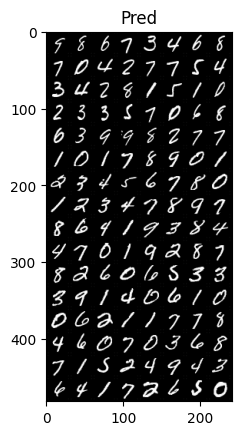

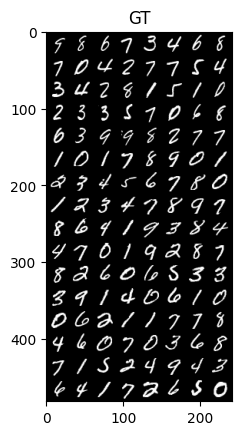

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.006116998381912708
The training time is 105.94312882423401 seconds.


In [ ]:
model = AutoEncoder_Conv(1, 128)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, training_time = trainingAndValidationLoop(model,
                                                    device,
                                                    reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

print(f"The training time is {training_time} seconds.")

epoch n°0
Training loss is   : 0.09507260005921125
Validation loss is : 0.0005355445027817041

epoch n°1
Training loss is   : 0.0005441930523375049
Validation loss is : 0.000284970854409039

epoch n°2
Training loss is   : 0.000289932698069606
Validation loss is : 0.00019492144492687656

epoch n°3
Training loss is   : 0.00019853990961564704
Validation loss is : 0.00013796969433315097

epoch n°4
Training loss is   : 0.0001408342555805575
Validation loss is : 0.00010647976523614489

epoch n°5
Training loss is   : 0.00010917592953774147
Validation loss is : 8.530269551556557e-05

epoch n°6
Training loss is   : 8.792040389380418e-05
Validation loss is : 7.060890311549883e-05

epoch n°7
Training loss is   : 7.269425477716141e-05
Validation loss is : 6.96952050930122e-05

epoch n°8
Training loss is   : 6.566455558640883e-05
Validation loss is : 5.1423128024907785e-05

epoch n°9
Training loss is   : 5.535133241210133e-05
Validation loss is : 4.683147417381406e-05



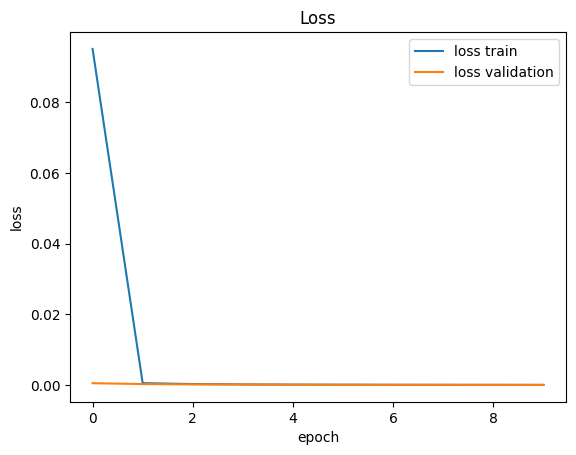

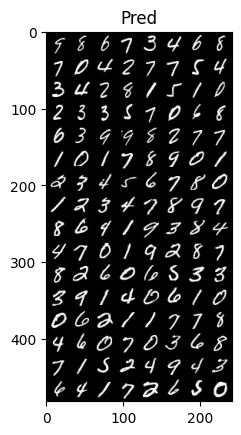

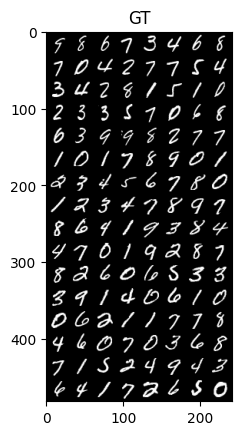

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.003374540712684393


tensor(0.0034, device='cuda:0')

In [ ]:
model = AutoEncoder_Conv(1, 512)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, _ = trainingAndValidationLoop(model,
                                                 device,
                                                 reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

In [ ]:
compression_values = [2**i for i in range(0, 11)]
test_loss_values, time_training_values = [], []

# Get all last values of training loss
for i in compression_values:
  model = AutoEncoder_Conv(1, i)

  _, _, time_training = trainingAndValidationLoop(model,
                                                  device,
                                                  printValues = False,
                                                  reshapeImage = False)
  losses = testingLoop(model,
                       plotLastBatch = False,
                       printDecompressionError = False,
                       reshapeImage = False)
  test_loss_values.append(losses.item())
  time_training_values.append(time_training)

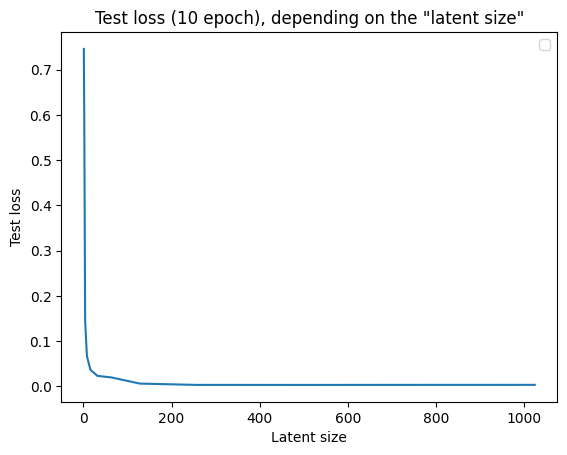

In [ ]:
plt.plot(compression_values, test_loss_values)
plt.legend()
plt.title("Test loss (10 epoch), depending on the \"latent size\"")
plt.xlabel("Latent size")
plt.ylabel("Test loss")
plt.show()

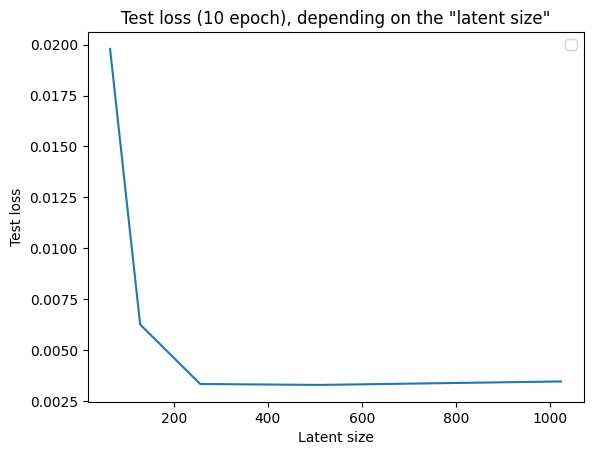

In [ ]:
plt.plot(compression_values[6:], test_loss_values[6:])
plt.legend()
plt.title("Test loss (10 epoch), depending on the \"latent size\"")
plt.xlabel("Latent size")
plt.ylabel("Test loss")
plt.show()

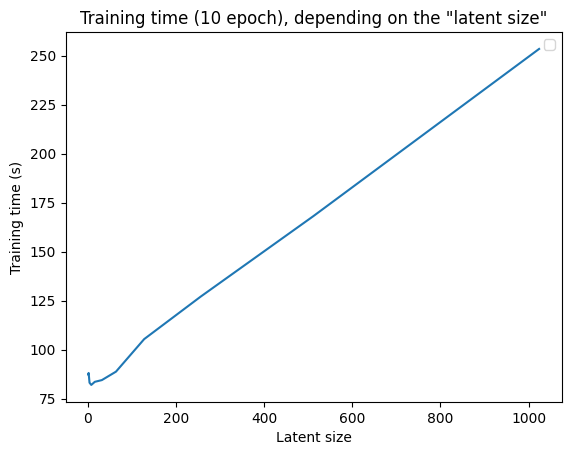

In [ ]:
plt.plot(compression_values, time_training_values)
plt.legend()
plt.title("Training time (10 epoch), depending on the \"latent size\"")
plt.xlabel("Latent size")
plt.ylabel("Training time (s)")
plt.show()

<font color=red> **Questions**</font>

* What is the training time?
> The training time is almost linear, and is 4 minutes for a latent size of 1024.
* Which model would you advice?
> If we want a good compromise between training time and quality, we should take a convolutional AutoEncoder with a reasonable latent size.


## c - Deeper Models

All the models we've created are only composed of 3 layers (not really deep):

      input layer => hidden layer => output layer

We can obviously stack more layers :
* Modify the Convolutional Encoder and the Decoder so that the AE becomes :
      input layer => hidden layer => hidden layer => hidden layer => output layer


We want the first and last hidden layer to have the same size

In [ ]:
# Modify the Encoder and the Decoder by adding one additional hidden layer.
class EncoderTwoLayers(nn.Module):
  """
  Conv Encoder Class
  """
  def __init__(self,input_channel, output_channel, kernel_size = 3):
    super().__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.kernel_size = kernel_size
    moyenne = int((self.input_channel + self.output_channel)/2)
    self.model = nn.Sequential(ConvDown(self.input_channel, moyenne, self.kernel_size),
                               ConvDown(moyenne, self.output_channel, self.kernel_size))

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

class DecoderTwoLayers(nn.Module):
  """
  Conv Decoder Class
  Be careful with the output attribute
  """
  def __init__(self,input_channel, output_channel, kernel_size = 3, output = True):
    super().__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.kernel_size = kernel_size
    self.output = output
    moyenne = int((self.input_channel + self.output_channel)/2)
    self.model= nn.Sequential(ConvUp(self.input_channel, moyenne, self.kernel_size, self.output),
                              ConvUp(moyenne, self.output_channel, self.kernel_size, self.output))

  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

# Recreate the AutoEncoder using EncoderTwoLayers and DecoderTwoLayers
class AutoEncoder_ConvTwoLayers(nn.Module):
  """
  AutoEncoder Class
  """
  def __init__(self, input_size, latent_size, output= True):
    super().__init__()
    self.input_size = input_size
    self.latent_size = latent_size
    self.output = output
    self.model = nn.Sequential(EncoderTwoLayers(self.input_size, self.latent_size),
                               DecoderTwoLayers(self.latent_size, self.input_size, output = self.output))


  def forward(self,x):
    """
    Send the data through the model and return the output
    """
    output = self.model(x)
    return output

# Print an example of the new model
print(AutoEncoder_ConvTwoLayers(1,128))

AutoEncoder_ConvTwoLayers(
  (model): Sequential(
    (0): EncoderTwoLayers(
      (model): Sequential(
        (0): ConvDown(
          (model): Sequential(
            (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
          )
        )
        (1): ConvDown(
          (model): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
          )
        )
      )
    )
    (1): DecoderTwoLayers(
      (model): Sequential(
        (0): ConvUp(
          (model): Sequential(
            (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
            (1): Sigmoid()
          )
        )
        (1): ConvUp(
          (model): Sequential(
            (0): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
            (1): Sigmoid()
          )
        )
      )
    )
  )
)


Retrain your Model for a Compressed Space of :
* 128
* 64

Compare the results

epoch n°0
Training loss is   : 0.22257811799645424
Validation loss is : 0.0007406775665003806

epoch n°1
Training loss is   : 0.0007526508183218539
Validation loss is : 0.0004481687879888341

epoch n°2
Training loss is   : 0.0004636381781892851
Validation loss is : 0.0003409349184948951

epoch n°3
Training loss is   : 0.00035451828152872623
Validation loss is : 0.0002795526830595918

epoch n°4
Training loss is   : 0.0002830767291015945
Validation loss is : 0.0002271976802148856

epoch n°5
Training loss is   : 0.00023270511155715212
Validation loss is : 0.00018454113887855783

epoch n°6
Training loss is   : 0.00019254922808613627
Validation loss is : 0.0001550926099298522

epoch n°7
Training loss is   : 0.00016313379746861755
Validation loss is : 0.00013235050719231367

epoch n°8
Training loss is   : 0.00013854447315679862
Validation loss is : 0.0001137161067163106

epoch n°9
Training loss is   : 0.00011882863400387577
Validation loss is : 9.724032497615553e-05



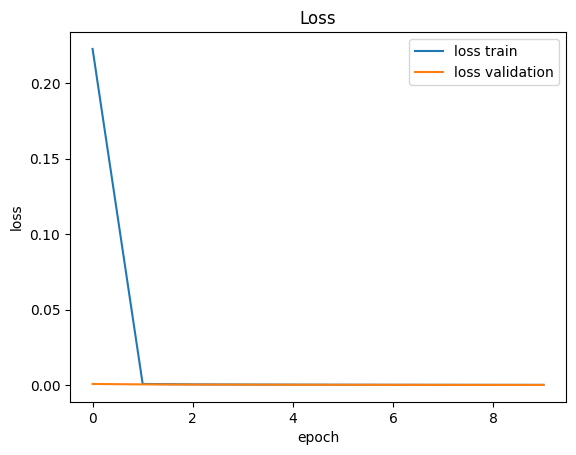

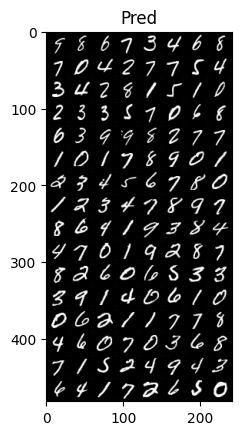

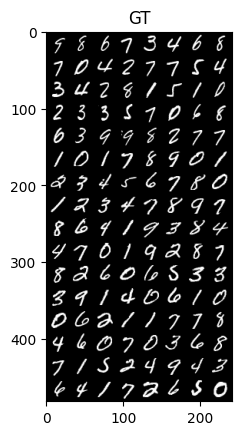

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.006872111931443214
The training time is 131.7381067276001 seconds.


In [ ]:
model = AutoEncoder_ConvTwoLayers(1, 64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, training_time = trainingAndValidationLoop(model, device, reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

print(f"The training time is {training_time} seconds.")

epoch n°0
Training loss is   : 0.09493413902819156
Validation loss is : 0.00031195762276183816

epoch n°1
Training loss is   : 0.0003167762770317495
Validation loss is : 0.00013781676243525

epoch n°2
Training loss is   : 0.00014875762572046368
Validation loss is : 9.229804491042159e-05

epoch n°3
Training loss is   : 9.795167497941292e-05
Validation loss is : 6.485874837380834e-05

epoch n°4
Training loss is   : 7.072929656715132e-05
Validation loss is : 5.218818769208156e-05

epoch n°5
Training loss is   : 5.444278685899917e-05
Validation loss is : 5.058066672063433e-05

epoch n°6
Training loss is   : 4.910820134682581e-05
Validation loss is : 3.703922138811322e-05

epoch n°7
Training loss is   : 3.991623962065205e-05
Validation loss is : 2.9696581077587324e-05

epoch n°8
Training loss is   : 2.9916340463387314e-05
Validation loss is : 2.5877933512674645e-05

epoch n°9
Training loss is   : 2.6272720060660503e-05
Validation loss is : 2.2817933313490357e-05



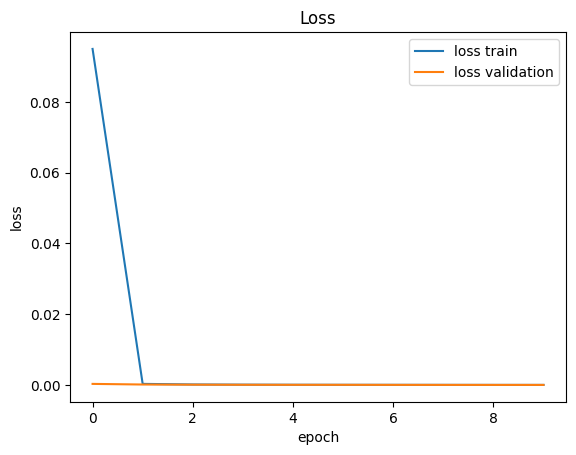

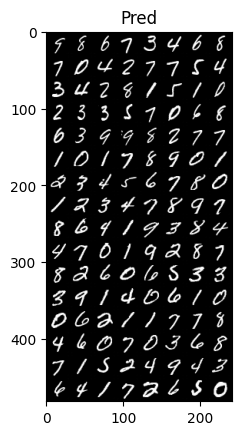

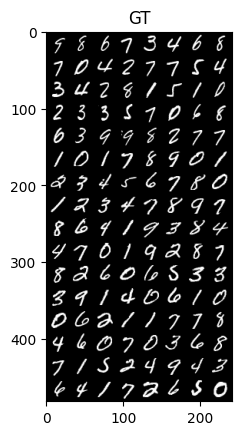

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.0016019911272451282
The training time is 161.18607091903687 seconds.


In [ ]:
model = AutoEncoder_ConvTwoLayers(1, 128)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_train, loss_val, training_time = trainingAndValidationLoop(model, device, reshapeImage = False)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, reshapeImage = False)

print(f"The training time is {training_time} seconds.")

# 5 - Where's that noise?

AE can be used to denoise image. That means that if there are some noise in input image, the AE will be able to reconsctruct the image without noise.

<img src="https://miro.medium.com/max/1400/1*z7SUcHkWp7jT1D_SqvTvgA.png" height=300>


In [ ]:
def add_noise(inputs, noise_factor):
  """
  By using torch.randn_like, create some noise and return a noisy input
  """
  noise = noise_factor * torch.randn_like(inputs)
  return  noise + inputs

In [ ]:
def plotNoisy(model, noise_factor, image = dataset[0][0]):
  print(f"Noise factor is : {noise_factor}")
  image_noisy = add_noise(image, noise_factor)

  # Send the Image through the model and plot the original image and the infered image
  image_reconstructed = model(image_noisy.to(device))
  fig,axarr = plt.subplots(1, 3)

  axarr[0].imshow(image.squeeze(0).squeeze(0).squeeze(0), cmap='gray_r')
  axarr[0].set_title('Original image')
  axarr[1].imshow(image_noisy.squeeze(0).squeeze(0).squeeze(0), cmap='gray_r')
  axarr[1].set_title('Noisy image')
  axarr[2].imshow(image_reconstructed.detach().cpu().squeeze(0).squeeze(0).squeeze(0), cmap='gray_r')
  axarr[2].set_title('Denoised image')
  plt.show()
  print("\n")

Noise factor is : 0.1


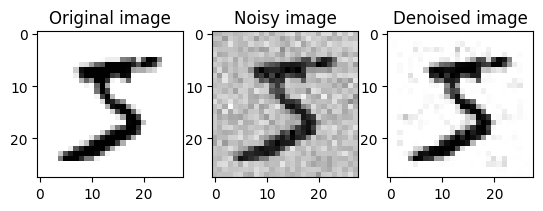



Noise factor is : 0.2


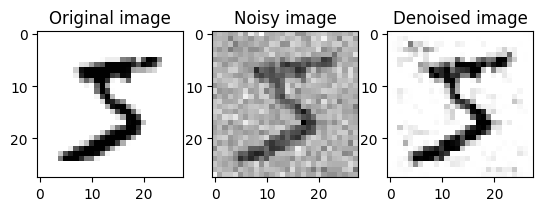



Noise factor is : 0.3


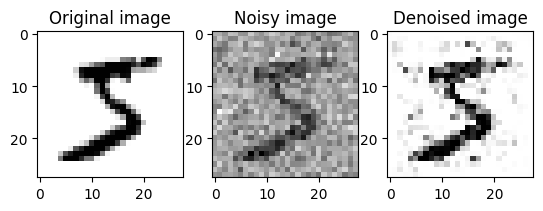



Noise factor is : 0.4


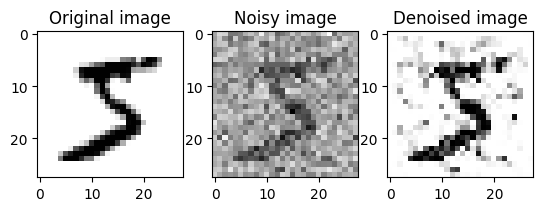



Noise factor is : 0.5


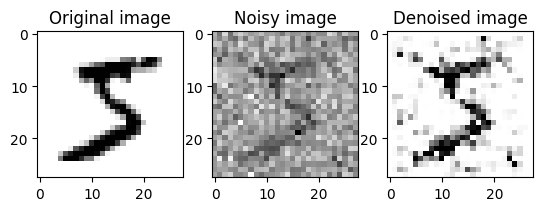

In [ ]:
model = AutoEncoder_ConvTwoLayers(1, 128)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainingAndValidationLoop(model,
                          device,
                          reshapeImage = False,
                          printValues = False)

plotNoisy(model, 0.1)
plotNoisy(model, 0.2)
plotNoisy(model, 0.3)
plotNoisy(model, 0.4)
plotNoisy(model, 0.5)


* <font color=red> **What can you tell ?** </font>
> It works really well when the noise is light. It almost disappears and you can almost get the original image back. The number is really recognisable and another AI trained to decode them would be able to find the value.
* <font color=red> **Does it work with lots of noise ?** </font>
> When the noise is low enough, it is indeed possible to remove it thanks to the model we have trained by finding an image very close to the original. This still allows us to guess the number.
>
>If the noise is too great, the reconstruction becomes too complex and there are certainly simpler methods of reconstructing the image that must exist.

# 6 - Getting some colors (optional)

In this part, you will try all the things you've seen previously on a new Dataset. Instead of black and white images, here we have RGB colored images.

You must :
* Check your Data
* Create the Dataloaders
* Create your Models
* Train your model for different parameters
* Test the model
* Provide some quantitative results on the behavior of your models.


## CIFAR10 : Colors and Classes

<font color=red> **Questions** </font>

Do the similar steps as before.

- What is the size of the train dataset?
> There are 55,000 items in the training dataset.
- What are the elements available in one piece of data? (image,label)
> The image is a photo. The label is an integer that classifies the image in one of the 10 image categories in the dataset (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
- What is the shape of one piece of data?
> Each piece of data is a 32 by 32 pixel square.
- What is the type of one piece of data?
> A data element is composed of the image which is a tensor and an integer.
- Plot few elements of the dataset using Matplotlib.



In [3]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test =  CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


The size of the new training and validation set is : 50000.
The size of the new testing set is : 10000.
Images are coded on tensor of size : torch.Size([3, 32, 32]).
Images are objects of type : <class 'torch.Tensor'>.
Labels are objects of type : <class 'int'>.
The value of target is 1, so the image is a picture of a(n) automobile


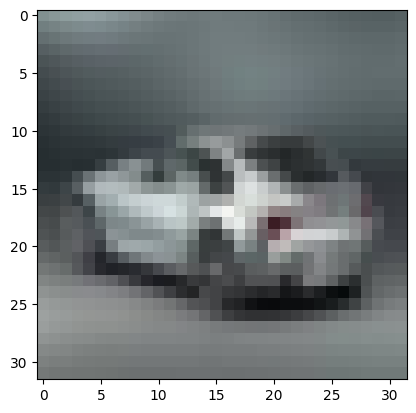

The value of target is 5, so the image is a picture of a(n) dog


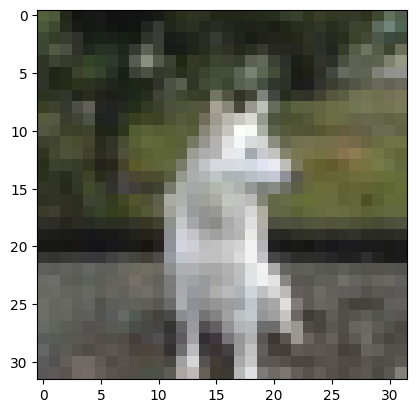

The value of target is 7, so the image is a picture of a(n) horse


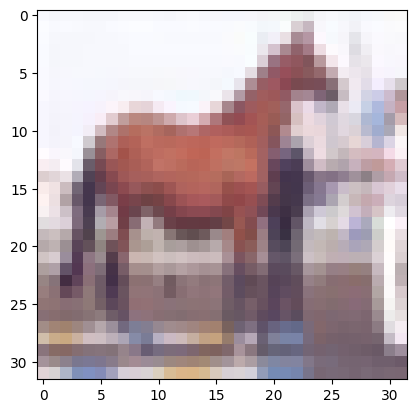

In [4]:
# Do all the things related to DATA here

cifar10_dict = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

cifar10_train, cifar10_val = random_split(dataset_train, [45000, 5000])
train_loader_rgb = DataLoader(cifar10_train, batch_size=128, drop_last = True)
val_loader_rgb = DataLoader(cifar10_val, batch_size=128, drop_last = True)
test_loader_rgb = DataLoader(dataset_test, batch_size=128, drop_last = True)

size_of_dataset_train = len(dataset_train)
size_of_dataset_test = len(dataset_test)

print(f"The size of the new training and validation set is : {size_of_dataset_train}.")
print(f"The size of the new testing set is : {size_of_dataset_test}.")
print(f"Images are coded on tensor of size : {cifar10_train[0][0].shape}.")
print(f"Images are objects of type : {type(cifar10_train[0][0])}.")
print(f"Labels are objects of type : {type(cifar10_train[0][1])}.")

# Display some data elements

data_250, target_250 = dataset_train[250]
print(f"The value of target is {target_250}, so the image is a picture of a(n) {cifar10_dict.get(target_250)}")
plt.imshow(data_250.permute(1, 2, 0))
plt.show()

data_750, target_750 = dataset_train[750]
print(f"The value of target is {target_750}, so the image is a picture of a(n) {cifar10_dict.get(target_750)}")
plt.imshow(data_750.permute(1, 2, 0))
plt.show()

data_412, target_412 = dataset_train[412]
print(f"The value of target is {target_412}, so the image is a picture of a(n) {cifar10_dict.get(target_412)}")
plt.imshow(data_412.permute(1, 2, 0))
plt.show()

* <font color=red> **Remark** </font>
>CIFAR10 contains all kinds of images that are all 32 by 32 pixels. We can see two of them above, which are pictures of a car, dog and a horse

In [21]:
# Test
model = AutoEncoder_MLP(input_size = 32*32*3,
                          compressed_space_size= 1)

# Print the model
print(f"The model we just created is :\n{model}")

The model we just created is :
AutoEncoder_MLP(
  (input): Sequential(
    (0): Linear(in_features=3072, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=1, out_features=3072, bias=True)
    (1): Sigmoid()
  )
)


epoch n°0
Training loss is   : 0.09793092161417008
Validation loss is : 0.07494783923029899

epoch n°1
Training loss is   : 0.07603476122021675
Validation loss is : 0.06592141836881638

epoch n°2
Training loss is   : 0.06683704107999802
Validation loss is : 0.057881177961826326

epoch n°3
Training loss is   : 0.058332886174321176
Validation loss is : 0.054113706946372984

epoch n°4
Training loss is   : 0.054271962493658066
Validation loss is : 0.0524142537266016

epoch n°5
Training loss is   : 0.05268676839768886
Validation loss is : 0.05119912102818489

epoch n°6
Training loss is   : 0.051717615500092504
Validation loss is : 0.05030749961733818

epoch n°7
Training loss is   : 0.05110814943909645
Validation loss is : 0.04982929714024067

epoch n°8
Training loss is   : 0.05024880245327949
Validation loss is : 0.04891471117734909

epoch n°9
Training loss is   : 0.049729932099580765
Validation loss is : 0.048606866225600245



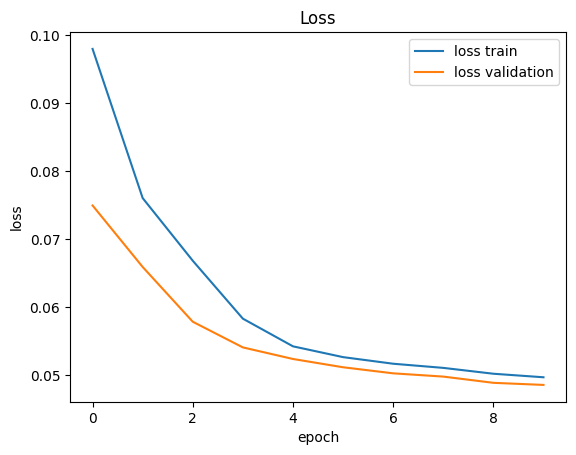

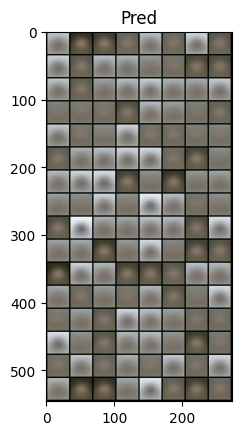

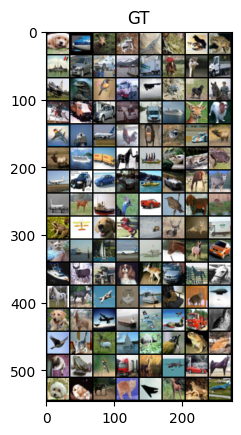

The decompression of the Encoded Test Dataset has an reconstruction error of: 3.4267513751983643
The training time is 87.99851393699646 seconds.


In [46]:
model = AutoEncoder_MLP(input_size = 32*32*3,
                        compressed_space_size = 1)

loss_train, loss_val, training_time = trainingAndValidationLoop(model,
                                                                device,
                                                                train_loader = train_loader_rgb,
                                                                val_loader = val_loader_rgb)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, test_loader = test_loader_rgb)

print(f"The training time is {training_time} seconds.")

epoch n°0
Training loss is   : 0.07590129189193248
Validation loss is : 0.02279991302639246

epoch n°1
Training loss is   : 0.02232872862368822
Validation loss is : 0.016915522795170546

epoch n°2
Training loss is   : 0.013634340837597847
Validation loss is : 0.009646052680909633

epoch n°3
Training loss is   : 0.009778615087270737
Validation loss is : 0.008504912303760648

epoch n°4
Training loss is   : 0.008654025150462985
Validation loss is : 0.007835651841014623

epoch n°5
Training loss is   : 0.007745179021731019
Validation loss is : 0.008160944702103734

epoch n°6
Training loss is   : 0.007508732937276363
Validation loss is : 0.0074823132250458006

epoch n°7
Training loss is   : 0.0076833320781588554
Validation loss is : 0.007013975037261843

epoch n°8
Training loss is   : 0.006943061389029026
Validation loss is : 0.007725388649851084

epoch n°9
Training loss is   : 0.0068242792971432206
Validation loss is : 0.006465971376746893



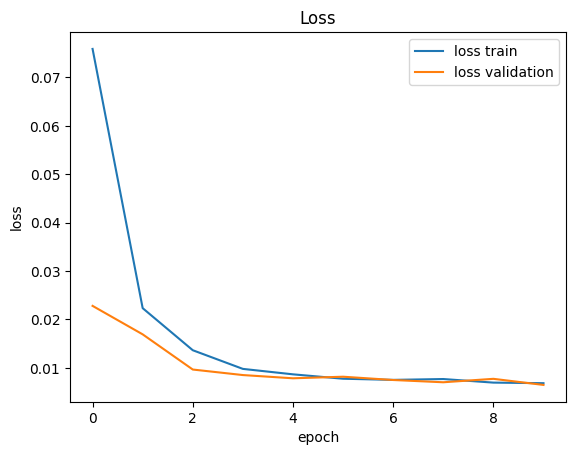

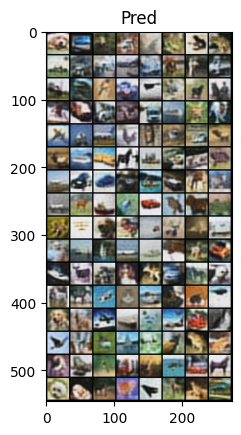

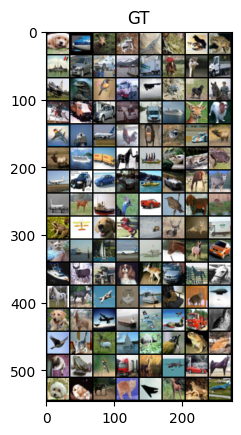

The decompression of the Encoded Test Dataset has an reconstruction error of: 0.4579731523990631
The training ime is 88.26771569252014 seconds.


In [47]:
model = AutoEncoder_MLP(input_size = 32*32*3,
                        compressed_space_size = 128)

loss_train, loss_val, training_time = trainingAndValidationLoop(model,
                                                                device,
                                                                train_loader = train_loader_rgb,
                                                                val_loader = val_loader_rgb)
plotTrainingAndValidationLoss(loss_train, loss_val)
testingLoop(model, test_loader = test_loader_rgb)
print(f"The training ime is {training_time} seconds.")